In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge


import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
transactions = pd.read_csv('../transactions_with_date.csv')

In [5]:
#transactions.amount = transactions.amount.apply(lambda x: round(x/11.2296))

In [4]:
train_transactions = transactions[transactions.amount < 0].copy()
#train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [7]:
#transactions.groupby("mcc_code").count().sort_values("amount", ascending = False).tail(20)

In [5]:
train_transactions.head()

customer_id  mcc_code  tr_type    amount  day        date   weekday  \
0     39026145      4814     1030  -2245.92    0  2014-08-01    Friday   
2     39026145      4829     2330 -56147.89    1  2014-08-02  Saturday   
3     39026145      5499     1010  -1392.47    1  2014-08-02  Saturday   
4     39026145      5499     1010   -920.83    2  2014-08-03    Sunday   
5     39026145      5541     1010 -14643.37    2  2014-08-03    Sunday   

   weekend  
0        0  
2        1  
3        1  
4        1  
5        1

In [9]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [10]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=sorted(train_transactions.day.unique()))
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

In [11]:
train_grid.head()

mcc_code  day
0      4814    0
1      4814    1
2      4814    2
3      4814    3
4      4814    4

In [12]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

In [13]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

In [14]:
train_transactions.head()

mcc_code  day  week_num  week_day  month_num  month_day       amount
0      4814    0         0         0          0          0 -11098744.26
1      4814    1         0         1          0          1  -7881825.53
2      4814    2         0         2          0          2  -6777480.45
3      4814    3         0         3          0          3  -9277943.73
4      4814    4         0         4          0          4  -9999757.21

In [17]:
train_transactions.month_num.unique()[1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [15]:
for day_shift in [-1, 0, 1]:
    for month_shift in train_transactions.month_num.unique()[1:]:
        train_shift = train_transactions.copy()
        train_shift['month_num'] += month_shift
        train_shift['month_day'] += day_shift
        train_shift['amount_day_{}_{}'.format(day_shift, month_shift)] = np.log(-train_shift['amount'] + 1)
        train_shift = train_shift[['month_num', 'month_day', 'mcc_code', 'amount_day_{}_{}'.format(day_shift, month_shift)]]

        train_transactions = pd.merge(train_transactions, train_shift, 
                                      on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)        
        test_transactions = pd.merge(test_transactions, train_shift, 
                                     on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)


In [16]:
train_transactions.head()

mcc_code  day  week_num  week_day  month_num  month_day       amount  \
0      4814    0         0         0          0          0 -11098744.26   
1      4814    1         0         1          0          1  -7881825.53   
2      4814    2         0         2          0          2  -6777480.45   
3      4814    3         0         3          0          3  -9277943.73   
4      4814    4         0         4          0          4  -9999757.21   

   amount_day_-1_1  amount_day_-1_2  amount_day_-1_3       ...         \
0              0.0              0.0              0.0       ...          
1              0.0              0.0              0.0       ...          
2              0.0              0.0              0.0       ...          
3              0.0              0.0              0.0       ...          
4              0.0              0.0              0.0       ...          

   amount_day_1_6  amount_day_1_7  amount_day_1_8  amount_day_1_9  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   amount_day_1_10  amount_day_1_11  amount_day_1_12  amount_day_1_13  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   amount_day_1_14  amount_day_1_15  
0              0.0              0.0  
1              0.0              0.0  
2              0.0              0.0  
3              0.0              0.0  
4              0.0              0.0  

[5 rows x 52 columns]

In [19]:
shift = 500
train = pd.get_dummies(train_transactions, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])
c = train.columns.difference(['amount'])

In [21]:
day_for_train = train_transactions.day.max() - 30
X_train = train_transactions[train_transactions.day <= day_for_train]
X_val = train_transactions[train_transactions.day > day_for_train]

train = pd.get_dummies(X_train, columns=['mcc_code'])
val = pd.get_dummies(X_val, columns=['mcc_code'])

train_all = pd.get_dummies(train_transactions, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

In [22]:
clf = LinearRegression()
clf.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))
#clf.fit(train[c], np.log(-train['amount'] + shift))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
pred_lin = np.e ** clf.predict(test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift
#pred_lin_log = clf.predict(val[c])

In [24]:
max(pred_lin)

inf

In [259]:
test_transactions['volume'] = pred_lin

In [261]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('TASK2_linreg_drop_new.csv', index=False)

## xgb

In [56]:
def RMSLE(y_true,y_pred, shuf):
    return np.sqrt(np.average((np.log(y_true + shuf) - np.log(y_pred + shuf)) ** 2))

In [25]:
import xgboost as xgb

In [27]:
param = {}
param['max_depth'] = 7
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['colsample_bylevel'] = 0.7

numround = 5000

In [28]:
day_for_train = train_transactions.day.max() - 30

In [30]:
X_train = train_transactions[train_transactions.day <= day_for_train]
X_val = train_transactions[train_transactions.day > day_for_train]


#train = pd.get_dummies(X_train, columns=['mcc_code'])
#val = pd.get_dummies(X_val, columns=['mcc_code'])

train = pd.get_dummies(train_transactions, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])
c = train.columns.difference(['amount'])

In [37]:
%%time
Xdatatrain = xgb.DMatrix(data=train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), label = np.log(-train.amount+500))
Xdatatest = xgb.DMatrix(data=test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1))

plst = list(param.items())
#watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            

#bst = xgb.train(plst, Xdatatrain, numround, evals = watchlist, verbose_eval = 10)

bst = xgb.train(plst, Xdatatrain, numround, verbose_eval = 10)

CPU times: user 57min 10s, sys: 34.5 s, total: 57min 44s
Wall time: 58min 18s


In [38]:
ypredxgb_log = bst.predict(Xdatatest)

In [39]:
pred_xgb = np.e ** ypredxgb_log - 500

In [40]:
test_transactions['volume'] = pred_xgb

In [41]:
test_transactions[['mcc_code', 'day', 'volume']].head()

mcc_code  day      volume
0      4814  457   9658588.0
1      4814  458  10772546.0
2      4814  459  12982134.0
3      4814  460  12621786.0
4      4814  461  14407126.0

In [42]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('TASK2_xgb_drop_new2.csv', index=False)

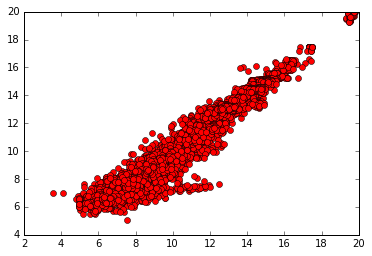

In [242]:
plt.plot(np.log(pred_xgb+1), np.log(pred_lin+1), 'ro')

In [183]:
shift = 500
#train = pd.get_dummies(train_transactions, columns=['mcc_code'])
train = pd.get_dummies(X_train, columns=['mcc_code'])
val = pd.get_dummies(X_val, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

c = train.columns.difference(['amount'])

In [28]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, n_estimators=200, silent=False, \
                          objective='reg:linear', nthread=24, \
                          subsample=0.6, colsample_bytree=0.6, colsample_bylevel=0.7)
model.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))

CPU times: user 5min 40s, sys: 4.43 s, total: 5min 45s
Wall time: 5min 50s


In [29]:
pred_xgb = np.e ** model.predict(val[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

In [30]:
min(pred_xgb)

-211.36255

In [31]:
pred_xgb1 = []

for i in pred_xgb:
    if i<0:
        i=0
        
    pred_xgb1.append(i)

In [32]:
pred_xgb2 = []

for i in pred_xgb:
    if i<0:
        i += min(pred_xgb)
        
    pred_xgb2.append(i)

In [33]:
pred_xgb3 = pred_xgb + abs(min(pred_xgb))

In [363]:
koef_xgb = 0.7
pred_compos = koef_xgb*np.array(pred_xgb) + (1-koef_xgb)*np.array(pred_lin)

In [364]:
pred_compos[:5]

array([ 10755565.91517   ,  11533669.15539794,  13107836.92935408,
        12890690.65699282,  14113794.66396089])

In [58]:
RMSLE(abs(X_val.amount),abs(pred_xgb),500)

1.7192819733817581

In [52]:
pred_df = pd.concat([X_val.mcc_code,pd.DataFrame(data=pred_compos, index=X_val.index, columns=["Amount_pred"])], axis=1)

In [81]:
r  = pd.concat([X_val[X_val.mcc_code == 5948].amount.apply(lambda x: -x), pred_df[pred_df.mcc_code == 5948]], axis=1)

In [82]:
r = r.drop(["mcc_code"], axis=1)

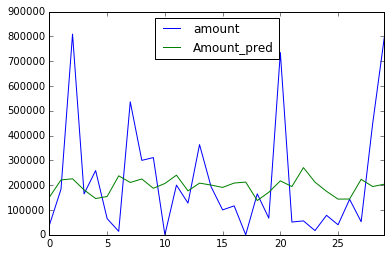

In [83]:
r.reset_index().drop(["index"], axis=1).plot()

## rf

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
shift = 500
train = pd.get_dummies(train_transactions, columns=['mcc_code'])
#train = pd.get_dummies(X_train, columns=['mcc_code'])
#val = pd.get_dummies(X_val, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

c = train.columns.difference(['amount'])

In [45]:
%%time
rf = RandomForestRegressor(n_estimators=500, oob_score=True, n_jobs=-1, verbose=1)

rf.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


CPU times: user 52min 5s, sys: 27.8 s, total: 52min 33s
Wall time: 14min 47s


In [46]:
pred_rf = np.e ** rf.predict(test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.9s finished


In [48]:
min(pred_rf)

-2.6091129257110879e-11

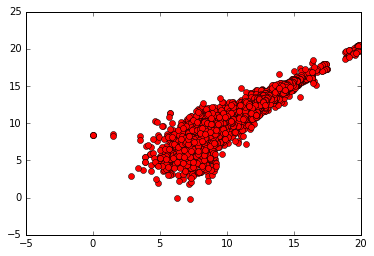

In [50]:
plt.plot(np.log(pred_rf+1), np.log(pred_xgb+1), 'ro')

In [54]:
min(pred_rf)

-2.6091129257110879e-11

In [52]:
pred_rf1 = []

for i in pred_rf:
    if i<0:
        i=0
        
    pred_rf1.append(i)

In [57]:
RMSLE(abs(X_val.amount),abs(np.array(pred_rf1)),500)

1.5270522031595868

In [269]:
koef_lin = 0.7
#koef_rf = 0.15

pred_compos1 = koef_lin*pred_lin + koef_rf*np.array(pred_rf1) + (1-koef_lin-koef_rf)*np.array(pred_xgb3)

In [59]:
test_transactions['volume'] = pred_rf1

In [60]:
test_transactions[['mcc_code', 'day', 'volume']].head()

mcc_code  day        volume
0      4814  457  9.438112e+06
1      4814  458  1.188157e+07
2      4814  459  1.239605e+07
3      4814  460  1.237638e+07
4      4814  461  1.225239e+07

In [61]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('TASK2_rf_drop_new.csv', index=False)

## Compose best models

In [63]:
TASK2_xgb_linreg_drop = pd.read_csv("TASK2_xgb_linreg_drop.csv")

In [64]:
TASK2_xgb_linreg_drop.head()

mcc_code  day        volume
0      4814  457  1.107856e+07
1      4814  458  1.168458e+07
2      4814  459  1.165006e+07
3      4814  460  1.161955e+07
4      4814  461  1.197303e+07

In [72]:
pred1 = TASK2_xgb_linreg_drop.volume

In [66]:
TASK2_XGB_drop_new = pd.read_csv("TASK2_xgb_drop_new.csv")

In [67]:
TASK2_XGB_drop_new.head()

mcc_code  day      volume
0      4814  457  10418931.0
1      4814  458  10702541.0
2      4814  459  11873132.0
3      4814  460  11932092.0
4      4814  461  11210779.0

In [69]:
pred2 = TASK2_XGB_drop_new.volume

In [87]:
pred_compos_best = pred1*0.5 + pred2*0.5

In [88]:
TASK2_XGB_drop_new.volume = pred_compos_best

In [89]:
TASK2_XGB_drop_new.head()

mcc_code  day        volume
0      4814  457  1.094004e+07
1      4814  458  1.147835e+07
2      4814  459  1.169690e+07
3      4814  460  1.168518e+07
4      4814  461  1.181296e+07

In [90]:
TASK2_XGB_drop_new.to_csv('TASK2_compose_best2_models_xgb_0.5.csv', index=False)